In [1]:
import os

curr_dir = os.path.split(os.getcwd())[1]
if curr_dir != "irl-environment-design":
    os.chdir("..")

import numpy as np

from src.utils.make_environment import (
    transition_matrix,
    Environment,
    insert_walls_into_T,
)

from src.utils.constants import ParamTuple

np.set_printoptions(linewidth=160, precision=2)

from src.utils.environment_design import EnvironmentDesign

from src.utils.inference.posterior import PosteriorInference

# 0. Setup
## 0.2 Setup the environment
N, M = 7,7

# TODO describe world
agent_R = np.zeros((N, M))
agent_R[N-1, 0] = 1
agent_R[N-1, M-1] = 3



# Start by making the agent we want to learn the policy of
agent_p = 0.9
agent_gamma = 0.8
p_true=0.9

agent_R = agent_R.flatten()
goal_states = np.where(agent_R != 0)[0]

true_params = ParamTuple(agent_p, agent_gamma, agent_R)

wall_states = [14]

T_true = transition_matrix(N, M, p=p_true, absorbing_states=goal_states)
T_True = insert_walls_into_T(T=T_true, wall_indices=wall_states)

big_small = Environment(
    N=N,
    M=M,
    T_true=T_true,
    wall_states=wall_states,
    R_true=agent_R,
    start_state=0,
    n_walls=None,
    goal_states=goal_states
)

env_design = EnvironmentDesign(base_environment=big_small, user_params=true_params, learn_what = "gamma, T")


/home/paul/.local/lib/python3.10/site-packages/numba/core/decorators.py:282: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


## Observe once to get posterior, e.g. conventional BIRL

In [2]:
env_design.run_n_episodes(n_episodes = 0, candidate_environments_args=None)

Started episode 0.
Finished episode 0.


In [3]:
# env_design.save(experiment_name="biased_likelihood")

In [2]:
import pickle

experiment_name = os.path.join("checkpoints", "biased_likelihood", "25.04.2024", "10:01:09")

def load_file(file_name):
    with open(file_name, 'rb') as file:
        data = pickle.load(file)
    return data

# Example usage
file_name = experiment_name
biased_likelihood_exp = load_file(file_name)

pos_inference = PosteriorInference(expert_trajectories=[biased_likelihood_exp["all_observations"][0]],
                                    resolution = 15,
                                    min_gamma = 0.5,
                                    max_gamma = 0.99,
                                    min_p = 0.5,
                                    max_p = 0.99)

pos_inference.calculate_posterior(num_episodes=1)

Calculate distribution of episode 0, e.g. the prior distribution.
Calculate distribution of episode 1.


In [3]:
from src.utils.optimization import soft_q_iteration

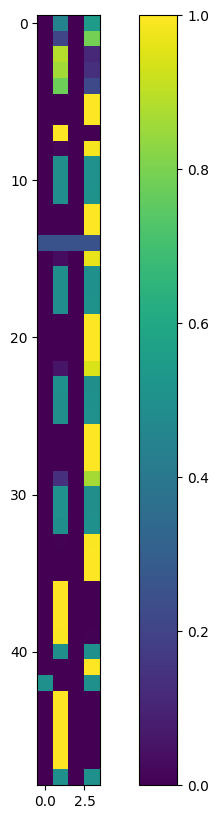

In [4]:
T_test = transition_matrix(N, M, p=0.99, absorbing_states=goal_states)
T_test = insert_walls_into_T(T=T_test, wall_indices=wall_states)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
im = ax.imshow(soft_q_iteration(R=agent_R, T_agent=T_test, gamma=agent_gamma, beta=1000))
plt.colorbar(im)

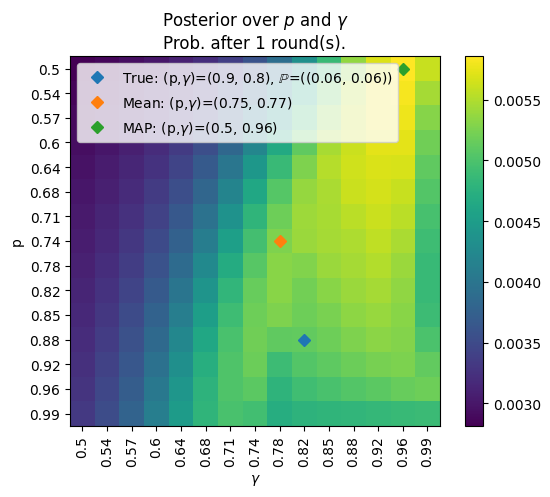

In [5]:
pos_inference.plot_posterior(episode=1, param_values=true_params)

In [6]:
pos = np.exp(pos_inference.posterior_distribution["episode=1"])
pos = pos/np.sum(pos)

### Unbias likelihood via $h$

In [25]:
ps = np.linspace(0.5, 0.99, 15)
gammas = np.linspace(0.5, 0.99, 15)
beta_agent = 20
from src.utils.constants import StateTransition
from src.utils.inference.likelihood import compute_log_likelihood

def expert_trajectory_log_likelihood(
    parameter_sample: ParamTuple,
    expert_trajectories: list[tuple[Environment, list[StateTransition]]],
    # goal_states: np.array
) -> float:
    
    '''
    Computes the log likelihood of an expert trajectory according to a parameter sample.
    Log-likelihood is averaged over length of trajectories.
    '''

    log_likelihood = 0.0
    behavior_optimal = True
    behavior_suboptimal = 0
    count_steps = 0

    for env, trajectories in expert_trajectories:
        assert env.goal_states is not None, "Add goal states to environment."
        T_agent = transition_matrix(env.N, env.M, p=parameter_sample.p, absorbing_states=env.goal_states)
        T_agent = insert_walls_into_T(T_agent, wall_indices=env.wall_states) #this is new
        policy, Q = soft_q_iteration(
            env.R_true, T_agent, gamma=parameter_sample.gamma, beta=beta_agent, return_Q = True
        )
        for traj in trajectories:
            len_traj = len(traj)
            log_likelihood += compute_log_likelihood(env.T_true, policy, traj)/len_traj
            count_steps += len_traj

            
        #Assert whether this trajectory is optimal according to this parameter_sample to unbias likelihood.
        #Behavior is optimal if the largest Q-Value is chosen.
        for traj in trajectories:
            for state, action, _ in traj:
                if not np.isclose(np.exp(beta_agent*(Q[state,action] - np.max(Q[state,:]))), 1, rtol=1e-1):
                    behavior_optimal = False
                    # print("Behavior is not optimal")
                    # print("state: ", state)
                    # print("action: ", action)
                    # print("optimal action: ", np.argmax(Q[state, :]))
                    # print("Q values: ", Q[state, :])
                    # break
                    behavior_suboptimal += 1

    if log_likelihood == -np.inf:
        print("log likelihood is negative infinity. sth is weird.")

    return log_likelihood, behavior_optimal, (behavior_suboptimal/count_steps)

In [8]:
expert_trajectory_log_likelihood(ParamTuple(p=0.6, gamma=0.99, R=None), [biased_likelihood_exp["all_observations"][0]])

(-0.7886792144399636, False, 0.15384615384615385)

In [26]:
log_likelihoods: np.ndarray = np.zeros(shape = (15, 15))
is_optimal_array: np.ndarray = np.zeros(shape = (15, 15))
ratio_suboptimal_array: np.ndarray = np.zeros(shape = (15, 15))

for idx_p, p in enumerate(ps):
    for idx_gamma, gamma in enumerate(gammas):

        # #If a ROI is given, only compute likelihoods for Region of Interest to save compute.
        # if self.region_of_interest is not None:
        #     if ((idx_p*self.resolution)+(idx_gamma)) not in self.region_of_interest:
        #         log_likelihoods[idx_p, idx_gamma] = -np.inf
        #         continue

        proposed_parameter = ParamTuple(p=p, gamma=gamma, R=None)

        likelihood, is_optimal, ratio_suboptimal = expert_trajectory_log_likelihood(
            proposed_parameter, [biased_likelihood_exp["all_observations"][0]]
        )
        log_likelihoods[idx_p, idx_gamma] = likelihood
        is_optimal_array[idx_p, idx_gamma] = is_optimal
        ratio_suboptimal_array[idx_p, idx_gamma] = ratio_suboptimal

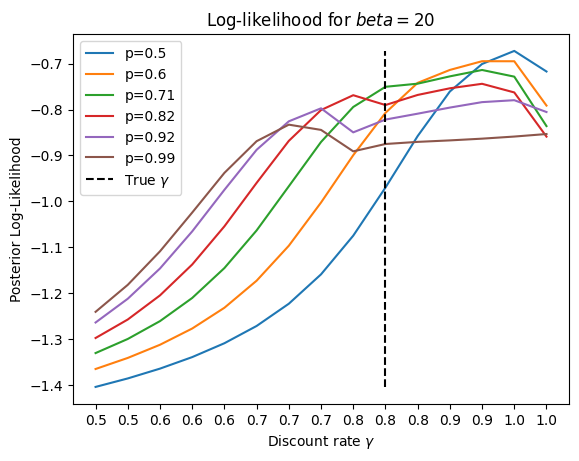

In [30]:
plt.plot(log_likelihoods[0,:], label=f"p={np.round(ps[0], 2)}")
plt.plot(log_likelihoods[3,:], label=f"p={np.round(ps[3], 2)}")
plt.plot(log_likelihoods[6,:], label=f"p={np.round(ps[6], 2)}")
plt.plot(log_likelihoods[9,:], label=f"p={np.round(ps[9], 2)}")
plt.plot(log_likelihoods[12,:], label=f"p={np.round(ps[12], 2)}")
plt.plot(log_likelihoods[14,:], label=f"p={np.round(ps[14], 2)}")

plt.xticks(np.arange(len(gammas)), np.round(gammas,1))
plt.xlabel("Discount rate $\gamma$")
plt.ylabel("Posterior Log-Likelihood")
plt.vlines(9, ymin=np.min(log_likelihoods), ymax=np.max(log_likelihoods), color="black", linestyles="--", label="True $\gamma$")
plt.title("Log-likelihood for $beta = 20$")
plt.legend()
plt.show()

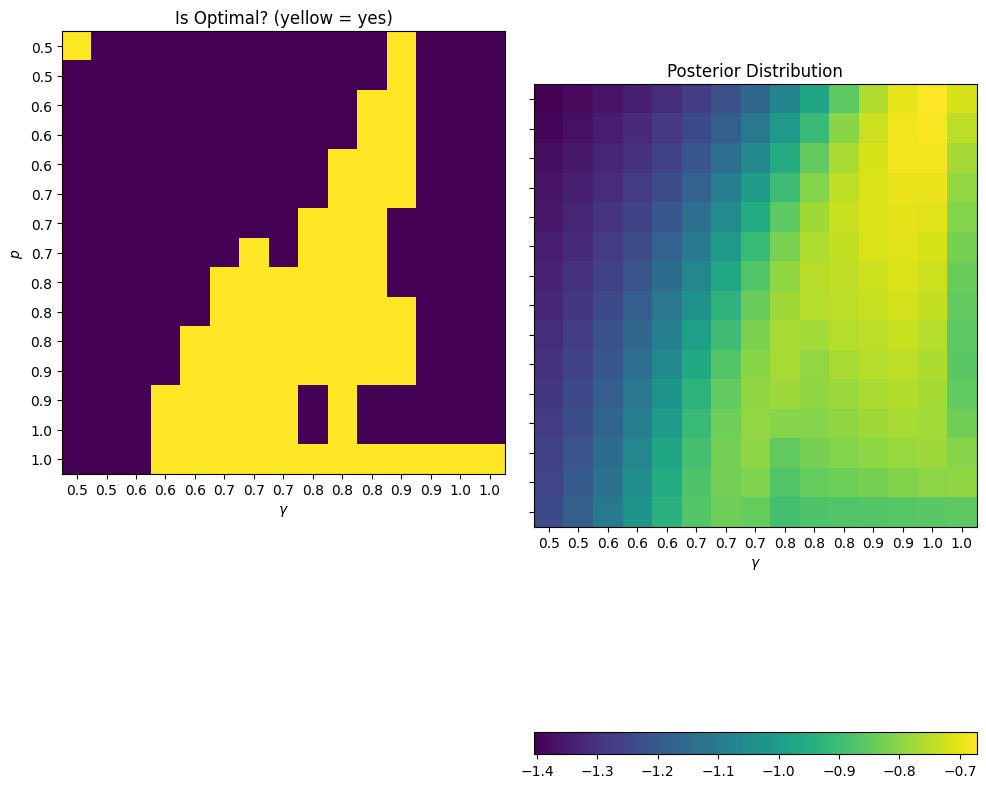

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(10, 14), sharey=True)

ax[0].imshow(is_optimal_array, origin="upper")
im = ax[1].imshow(log_likelihoods, origin="upper")
ax[0].set_xlabel("$\gamma$")
ax[0].set_ylabel("$p$")
ax[1].set_xlabel("$\gamma$")

ax[0].title.set_text("Is Optimal? (yellow = yes)")
ax[1].title.set_text("Posterior Distribution")

ax[0].set_xticks(np.arange(len(gammas)), gammas)
ax[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{gammas[int(x)]:.1f}"))
ax[0].set_yticks(np.arange(len(ps)), np.round(ps,1))
ax[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{ps[int(x)]:.1f}"))
ax[1].set_xticks(np.arange(len(gammas)), gammas)
ax[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{gammas[int(x)]:.1f}"))

fig.colorbar(im, orientation='horizontal')  

fig.tight_layout()